In [8]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    background-color: #9467bd;
    padding: 20px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: #ff7f00;
}

h2 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    background-color: #de9ed6;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: #800080;
}

h3 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    background-color: #756bb1;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: #393b79;
}

body, p {
    font-family: ariel;
    font-size: 18px;
    color: black;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
}

</style>
""")

# Preparing Ingredients to Cook: Creation of Data for LLM Training

Crafting the perfect training ground for Large Language Models (LLMs) is like preparing a recipe for success. Think of LLMs as hungry learners ready to feast on a diverse mix of data. It's not just about throwing words together; we carefully create prompts, like tasty instructions, to guide LLMs through different language tasks – from simple summaries to more complex challenges. Once we have this flavorful mix of data, we divide it into training and validation sets. The training set is the main course, helping LLMs recognize language patterns, while the validation set ensures they truly understand the information. So, the secret sauce to LLM brilliance lies in this thoughtful blend of diverse data, purposeful prompts, and a bit of training and validation magic, paving the way for smarter communication and interaction down the road.

Contents:

1. Importing Libraries and Dependencies
2. Configurations
3. Helper Functions

    a. Joining data from different sources
    
    b. Preparing data with prompts
    
    c. Splitting data to training set and validation set
  

Data Sources:
1. [Kaggle - LLM Science Exam](https://www.kaggle.com/competitions/kaggle-llm-science-exam/leaderboard)
2. [📊6.5k train examples for LLM Science Exam📝](https://www.kaggle.com/datasets/radek1/additional-train-data-for-llm-science-exam)

## Flowchart for better understnading

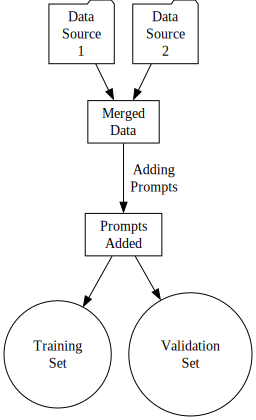

In [2]:
import pydot
from IPython.display import SVG


dot_graph = pydot.Dot(graph_type='digraph')

data_src_1_node = pydot.Node('Data\nSource\n1')
data_src_1_node.set_shape('folder')
dot_graph.add_node(data_src_1_node)

data_src_2_node = pydot.Node('Data\nSource\n2')
data_src_2_node.set_shape('folder')
dot_graph.add_node(data_src_2_node)

data_merged_node = pydot.Node('Merged\nData')
data_merged_node.set_shape('file')
dot_graph.add_node(data_merged_node)

data_prompting_node = pydot.Node('Prompts\nAdded')
data_prompting_node.set_shape('rect')
dot_graph.add_node(data_prompting_node)

data_training_set_node = pydot.Node('Training\nSet')
data_training_set_node.set_shape('circle')
dot_graph.add_node(data_training_set_node)

data_testing_set_node = pydot.Node('Validation\nSet')
data_testing_set_node.set_shape('circle')
dot_graph.add_node(data_testing_set_node)

data_src_1_merge_edge = pydot.Edge(data_src_1_node, data_merged_node)
dot_graph.add_edge(data_src_1_merge_edge)

data_src_2_merge_edge = pydot.Edge(data_src_2_node, data_merged_node)
dot_graph.add_edge(data_src_2_merge_edge)

data_merge_prompt_edge = pydot.Edge(data_merged_node, data_prompting_node)
data_merge_prompt_edge.set_label('Adding\nPrompts')
dot_graph.add_edge(data_merge_prompt_edge)

data_prompt_train_edge = pydot.Edge(data_prompting_node, data_training_set_node)
dot_graph.add_edge(data_prompt_train_edge)

data_prompt_test_edge = pydot.Edge(data_prompting_node, data_testing_set_node)
dot_graph.add_edge(data_prompt_test_edge)

dot_graph.write_svg('flow.svg')
SVG('flow.svg')

## Importing Libraries and Dependencies

In [ ]:
import gc
import os
import pandas as pd
pd.set_option('display.max_colwidth', 500)

from tqdm import tqdm
from string import Template
from dataclasses import dataclass

## Creating Configurations

In [ ]:
@dataclass(frozen=True)
class Config:
    PWD = os.getcwd()
    TRAIN_FILE_FROM_COMPETITION: str='/kaggle/input/kaggle-llm-science-exam/train.csv'
    EXTRA_EXAMPLES: str='/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv'
    TRAIN_EXAMPLES_6K: str='/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv'
    FINAL_DATA_SAMPLES_TO_DISPLAY: int=5
    SPLIT_DATA: bool=True
    SAVE_MERGED_DATA: bool=True
    MERGED_DATA_NAME: str='final_data.csv'
    TRAINING_RATIO: float=0.75
    TRAIN_CSV_FILE_NAME: str='final_training_data.csv'
    VALID_CSV_FILE_NAME: str='final_validation_data.csv'
    SEQUENCE_MAX_LENGTH: int=2**12

## Helper Functions

### Function to merge dataframes from different sources

In [ ]:
def merge_data_sources():
    """
    Merges and preprocesses data from different sources to create a consolidated dataframe for training models.

    Reads the following datasets:
    1. train.csv from competition data.
    2. 6000_train_examples.csv from 6.5k train examples for LLM Science Exam.
    3. extra_train_set.csv from additional 6.5k train examples for LLM Science Exam.

    Drops the 'id' column from the competition data.
    Aligns column names and concatenates the three dataframes into a single dataframe for model training.
    
    Displays information about the size of each dataframe (number of rows) for verification.
    Displays a sample of the final merged dataframe for visual inspection.
    
    Checks for and prints the number of duplicate rows present in the final dataset.

    Cleans up memory by deleting intermediate dataframes.

    Returns:
    - df: Final merged dataframe for model training.
    """
    # Read train.csv from competition data
    df1 = pd.read_csv(Config.TRAIN_FILE_FROM_COMPETITION)
    df1.drop(columns=['id'], inplace=True)
    column_names = df1.columns

    # Read 6000_train_examples.csv from 6.5k train examples for LLM Science Exam 
    df2 = pd.read_csv(Config.TRAIN_EXAMPLES_6K)
    df2 = df2[column_names]

    # Read extra_train_set.csv from 6.5k train examples for LLM Science Exam 
    df3 = pd.read_csv(Config.EXTRA_EXAMPLES)
    df3 = df3[column_names]

    # # Join the three dataframes to obtain a single dataframe  on which models will be trained
    df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
    df.reset_index(inplace=True, drop=True)

    # # Check if properly joined
    display(
        pd.DataFrame(
            data = {
                'Dataframes' : ['train.csv from competition data', '6000_train_examples.csv from 6.5k train examples for LLM Science Exam', 'extra_train_set.csv from 6.5k train examples for LLM Science Exam ', 'Final Training Dataframe'],
                'Number of rows' : [len(df1),len(df2),len(df3),len(df)]
            }
        ).style.set_caption("Dataframe Sizes")
    )

    print('\n')

    # Display Sample Rows from Merged Data
    display(
        df.sample(Config.FINAL_DATA_SAMPLES_TO_DISPLAY).style.set_caption(
            f"Final Merged Dataframe ({Config.FINAL_DATA_SAMPLES_TO_DISPLAY} Sampled rows)"
        )
    )

    print(f'\nNumber of duplicate rows present in the final dataset: {df.duplicated().sum()}')
    
    del df1
    del df2
    del df3
    gc.collect()

    return df

### Making Prompts out of Data

In [ ]:
def prepare_final_df(
        data: pd.DataFrame,
        instruction: str='As your response to the prompt, select the most appropriate option among A, B, C, D, and E.'
    ):
     """
    Prepares the final dataframe with formatted prompts and answers.

    Args:
    - data (pd.DataFrame): Input dataframe containing prompt information.
    - instruction (str): Instruction to be included in the prompts.

    Returns:
    - pd.DataFrame: Final dataframe with formatted prompts and answers.
    """
    
    def prepare_final_prompt(
            row_data: pd.core.series.Series,
            instruction: str=instruction
        ):
        """
        Prepares a final prompt by formatting the instruction, prompt, options (A-E), and the correct answer.

        Args:
        - row_data (pd.core.series.Series): Data for a single row containing prompt details.
        - instruction (str): Instruction to be included in the prompts.

        Returns:
        - str: Formatted final prompt.
        """
        try:
            template = Template(
                            '### Instruction: \n \
                             $instruction \n\n   \
                             ### Prompt \n       \
                             $prompt \n\n        \
                             A) $a \n            \
                             B) $b \n            \
                             C) $c \n            \
                             D) $d \n            \
                             E) $e \n\n          \
                             ### Answer:\n     \
                             $ans'
                        )
            final_prompt = template.substitute(
                                instruction = instruction,
                                prompt = row_data['prompt'],
                                a = row_data['A'],
                                b = row_data['B'],
                                c = row_data['C'],
                                d = row_data['D'],
                                e = row_data['E'],
                                ans = row_data['answer']
                            )
            
            del row_data
            gc.collect()
            
            return final_prompt
        except Exception as e:
            raise(e)

    def select_prompts_with_a_max_length(
            data: pd.DataFrame,
            max_length: int=Config.SEQUENCE_MAX_LENGTH
        ):
        """
        Selects prompts with a maximum length less than the specified value.

        Args:
        - data (pd.DataFrame): Input dataframe containing prompt details.
        - max_length (int): Maximum length allowed for prompts.

        Returns:
        - pd.DataFrame: Dataframe with selected prompts.
        """
        try:
            keep_indices = []
            for index, prompt in tqdm(
                                        data.iterrows(),
                                        desc='Fetching Indices to keep',
                                        total=data.shape[1]
                                   ):
                text_sequence_length = len(data['final_prompts'][index])
                if text_sequence_length < max_length:
                    keep_indices.append(int(index))

            # Select the indices
            data = data.loc[keep_indices]
            data.reset_index(drop=True, inplace=True)
            return data
        except Exception as e:
            raise(e)

    try:
        # Prepare the final prompts
        final_prompts = []
        for idx, row_data in tqdm(
                                    data.iterrows(), 
                                    desc='Creating final prompts',
                                    total=data.shape[1]
                             ):
            final_prompts.append(
                    prepare_final_prompt(row_data=row_data)
            )

        # Prepare the final answers
        final_answers = data['answer'] # encode_answers(data=data)
        final_data = pd.DataFrame(
                        data={
                                'final_prompts':final_prompts,
                                'final_answers':final_answers
                            }
                        )
        final_data = select_prompts_with_a_max_length(final_data)

        display(
            final_data.sample(Config.FINAL_DATA_SAMPLES_TO_DISPLAY).style.set_caption("Final Data with Prompts")
        )

        if Config.SAVE_MERGED_DATA:
            final_data.to_csv(Config.MERGED_DATA_NAME, index=False)
            print(f'\nSaving Data to {Config.PWD}/{Config.MERGED_DATA_NAME}')

        del data
        gc.collect()

        return final_data
    except Exception as e:
        raise(e)

### Creating Data

In [ ]:
def train_valid(df:pd.DataFrame):
    """
    Splits the dataframe into training and validation sets and saves them as CSV files.

    Args:
    - df (pd.DataFrame): Input dataframe containing training and validation data.

    Raises:
    - Exception: If an error occurs during the process.
    """
    try:
        if Config.SPLIT_DATA:

            for i in tqdm(range(1), desc='\nSplitting merged data'):
                train_df = df[: int(len(df)*Config.TRAINING_RATIO)]
                valid_df = df[int(len(df)*Config.TRAINING_RATIO)+1:]

            for i in tqdm(range(1), desc=f'\nSaving final training data to {Config.PWD}/{Config.TRAIN_CSV_FILE_NAME}'):
                train_df.to_csv(Config.TRAIN_CSV_FILE_NAME, index=False)
                display(
                    train_df.sample(Config.FINAL_DATA_SAMPLES_TO_DISPLAY).style.set_caption("Final Training Data with Prompts")
                )

            for i in tqdm(range(1), desc=f'\nSaving final validation data to {Config.PWD}/{Config.VALID_CSV_FILE_NAME}'):
                valid_df.to_csv(Config.VALID_CSV_FILE_NAME, index=False)
                display(
                    valid_df.sample(Config.FINAL_DATA_SAMPLES_TO_DISPLAY).style.set_caption("Final Validation Data with Prompts")
                )
                
            del train_df
            del valid_df
            gc.collect()

        del df
        gc.collect()
        
    except Exception as e:
        raise(e)

## Preparation of Ingredients (data)

In [ ]:
df = merge_data_sources()
df = prepare_final_df(df)
train_valid(df)

## Storiing Ingredients (data) for cooking

In [ ]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/final_data.csv')
FileLink(r'/kaggle/working/final_training_data.csv')
FileLink(r'/kaggle/working/final_validation_data.csv')

### Next Steps

[Cooking](https://www.kaggle.com/code/adityadawn/training-llm-using-accelerate-and-w-b?scriptVersionId=156219026)

Serving

Special Mention: [Flowcharts PyDot](https://www.kaggle.com/code/kmader/flowcharts-pydot#Data-Flow-LungStage)

# Please upvote if you like